## Overview
### Assumptions
- Computable's initial support of market is $500 in ETH
- Split that over 3 initial supporters

### Goals

- Early price of CMT should be between \\$0.10 and \\$1.00. Inexpensive but not so inexpensive to be fractions of pennies.
- Low threshold (< \\$10) to buy a stake's worth of CMT, even if price to match Computable's voting power is \\$500 (or more as market grows).
- Significant financial bias towards makers. For FFA it's better to sacrifice supporter ROI for a market with higher diversity / quality / volume of listings and purchases. This means a higher percentage for makers and lower for the reserve.
- Cost per mb is hard because with a diversity of file types, the size of a file really doesn't represent the value of the file well at all. Assume a sweet spot of ~50 mb files. Set that price at $5.
- Low listing reward so that motivation to makers is to sell their data, not just get it listed

In [1]:
from helpers import toWei, fromWei, UsdEthConverter, Market

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

usd = UsdEthConverter(162) # $162 per ETH on 10/24

In [2]:
params = {
    'price_floor':          5e5,   # wei per billion CMT-wei

    'spread':               110,  # percentage
    
    'list_reward':          toWei(2, 'CMT'),
    # Keep this low but not negligible. Excpet FFA to potentially get many valid candidates
    # that are voted in but never bought. Don't let these cruft listings soak up too much 
    # capitalization. Incentive for makers should be listing something that will sell.
    
    'stake':                toWei(10, 'CMT'),
    
    'backend_payment':      5, # percent
    
    'maker_payment':        70, # percent. 
    
    # reserve payment:      100 - backend_payment - maker_payment
    
    'usd_cost_per_mbyte':       0.10 # $USD per Mbyte
    # A scan through some Kaggle datasets, the size of videos, photos, and sound files, and came
    # up with 100MB as a reference listing size. Let's make buying this reference 1 ETH. You can 
    # easily get 3 ETHs from the faucet and buy 3 things.
}

In [3]:
# Convert human readable units to units used by market codebase
params['reserve_payment'] = 100 - params['backend_payment'] - params['maker_payment']
params['cost_per_byte'] = toWei(usd.toEth(params['usd_cost_per_mbyte']), 'ETH') / 1e6

for k in params:
    print (f"{k}: {params[k]}")

price_floor: 500000.0
spread: 110
list_reward: 2e+18
stake: 1e+19
backend_payment: 5
maker_payment: 70
usd_cost_per_mbyte: 0.1
reserve_payment: 25
cost_per_byte: 617283950.617284


## Set up market with 3 creators each investing $166

In [4]:
total_creator_usd = 500
n_creators = 3
creator_usd = total_creator_usd/n_creators
##################

m = Market(params)
m.market_total += toWei(1, 'CMT')
# m.market_total += toWei(1e-3, 'CMT')


for i in range(3):
    price = m.get_human_support_price()
    cmt = creator_usd / usd.fromEth(price)
    print (f"\n• Supporter {i+1} pays ${round(usd.fromEth(price),2)} per CMT")
    print (f"Gets {round(cmt):,} CMT")
    print (f"Has {round(cmt / fromWei(params['stake'], 'CMT')):,} stakes")
    m.support(usd.toEth(creator_usd))
    
CREATOR_BLOCK_SIZE = m.market_total


print (f"\nCMT support price is now ${round(usd.fromEth(m.get_human_support_price()),2)}")
print (f"CMT withdraw price is now ${round(usd.fromEth(m.get_withdraw_price()),2)}")
print ("\n")

print (f"• Market reserve is {round(fromWei(m.reserve, 'ETH'),3)} ETH (${round(usd.fromEth(fromWei(m.reserve, 'ETH')),2)})")
print (f"• Total market tokens is {round(fromWei(m.market_total, 'CMT'), 2)} CMT")
       
# print ("\n")
# print (f"• The creator has {int(CREATOR_BLOCK_SIZE/params['stake'])} stakes of voting power")

# listings_approved_to_match_creator = CREATOR_BLOCK_SIZE / params['list_reward']
# print (f"• It takes {int(listings_approved_to_match_creator)} listings to match creator voting power")


• Supporter 1 pays $0.08 per CMT
Gets 2,058 CMT
Has 206 stakes

• Supporter 2 pays $0.17 per CMT
Gets 980 CMT
Has 98 stakes

• Supporter 3 pays $0.2 per CMT
Gets 826 CMT
Has 83 stakes

CMT support price is now $0.22
CMT withdraw price is now $0.13


• Market reserve is 3.086 ETH ($500.0)
• Total market tokens is 3865.13 CMT


## Scenario: simple sequence of supporting, listing, buying

In [5]:
iters = 1000
buys_per_iter = 10

support_prices_usd = np.zeros(iters)
withdraw_prices_usd = np.zeros(iters)
buy_total_volume_usd = np.zeros(iters)

support_usd = 5.0
buy_mb = 10.0

buy_volume_mb = 0

for i in range(iters):
    m.support(usd.toEth(support_usd))
    m.list()
    for j in range(10):
        m.buy(buy_mb)
        buy_volume_mb += buy_mb
    
    support_prices_usd[i] = usd.fromEth(m.get_human_support_price())
    withdraw_prices_usd[i] = usd.fromEth(m.get_withdraw_price())
    buy_total_volume_usd[i] = buy_volume_mb * params['usd_cost_per_mbyte']

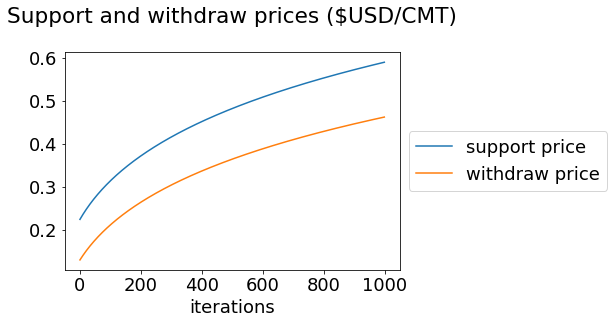

In [6]:
plt.rc('font', size=18)
fig, ax = plt.subplots()

x = np.arange(0, iters, 1)
ax.plot(x, support_prices_usd)
ax.plot(x, withdraw_prices_usd)
ax.legend(['support price', 'withdraw price'], loc='center left', bbox_to_anchor=(1, 0.5))

ax.set(xlabel='iterations', title='Support and withdraw prices ($USD/CMT)\n')
plt.show()

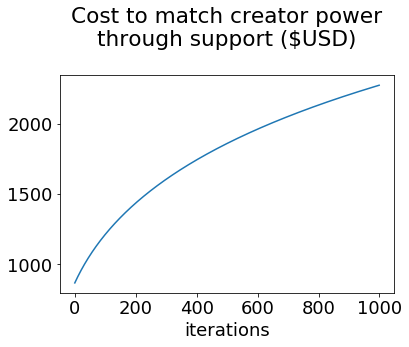

In [7]:
costs_to_match_creator = fromWei(CREATOR_BLOCK_SIZE, 'CMT') * support_prices_usd

fig, ax = plt.subplots()
ax.plot(x, costs_to_match_creator)
ax.set(xlabel='iterations', title='Cost to match creator power\nthrough support ($USD)\n')
plt.show()

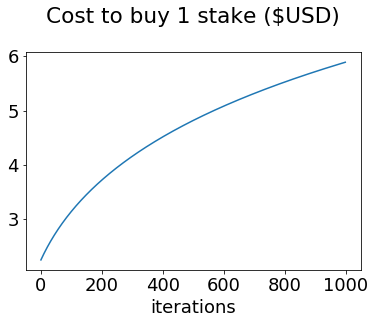

In [8]:
costs_to_stake = fromWei(params['stake'], 'CMT') * support_prices_usd

fig, ax = plt.subplots()
ax.plot(x, costs_to_stake)
ax.set(xlabel='iterations', title='Cost to buy 1 stake ($USD)\n')
plt.show()

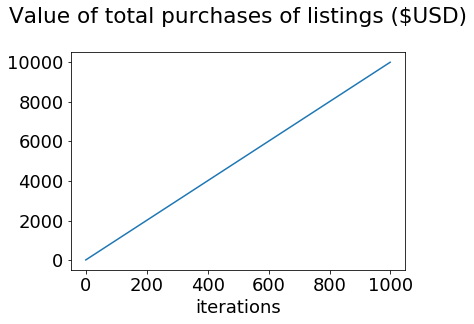

In [9]:
fig, ax = plt.subplots()
ax.plot(x, buy_total_volume_usd)
ax.set(xlabel='iterations', title='Value of total purchases of listings ($USD)\n')
plt.show()

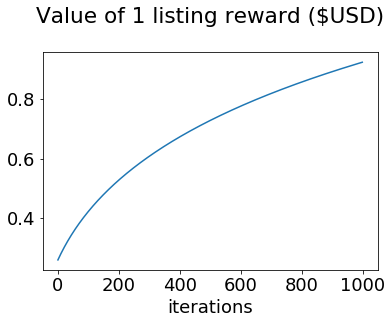

In [10]:
reward = fromWei(params['list_reward'], 'CMT') #CMT
prices = withdraw_prices_usd
usd_rewards = reward * prices

fig, ax = plt.subplots()
ax.plot(x, usd_rewards)
ax.set(xlabel='iterations', title='Value of 1 listing reward ($USD)\n')
plt.show()

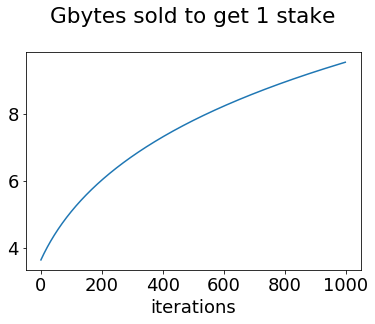

In [11]:
mb_sold_to_stake = costs_to_stake / (fromWei(params['cost_per_byte'], 'ETH') * 1e6)
fig, ax = plt.subplots()
ax.plot(x, mb_sold_to_stake/1000)
ax.set(xlabel='iterations', title='Gbytes sold to get 1 stake\n')
plt.show()

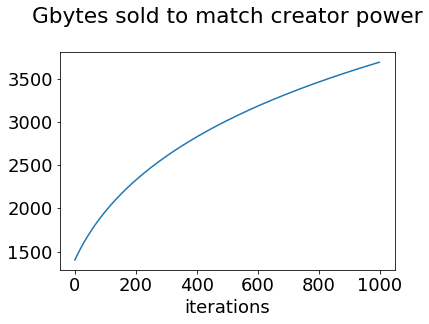

In [12]:
mb_sold_to_match_creator = costs_to_match_creator / (fromWei(params['cost_per_byte'], 'ETH') * 1e6)
fig, ax = plt.subplots()
ax.plot(x, mb_sold_to_match_creator/1000)
ax.set(xlabel='iterations', title='Gbytes sold to match creator power\n')
plt.show()